The objective of this notebook is to explore and experiment with different oversampling techniques to balance our dataset.

Approach: 

1. Calculate for each isolated technique, results of BOW and MNB for each OVERSAMPLE_FACTORS = [1.25, 1.5, 2.0] of the minority class.

Techniques are found in the file utils/textaug_techniques.py and explained in the EXPERIMENTS_GUIDELINE.md

## Datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import sys
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', stream=sys.stdout)
import warnings
warnings.filterwarnings('ignore')

import os
sys.path.append(os.path.abspath("../utils"))
sys.stdout.flush()
from textaug_techniques import TextAugmentation





In [27]:
train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")
val = pd.read_csv("../../data/gold/validation.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']

In [28]:
y_train.value_counts()


target
0    3606
1     517
Name: count, dtype: int64

In [29]:
y_train.value_counts(normalize=True)

target
0    0.874606
1    0.125394
Name: proportion, dtype: float64

## Oversampling 

In [30]:
OVERSAMPLE_FACTORS = [1.25, 1.5, 2.0] 

In [ ]:


augmenter = TextAugmentation(qw=0, aa=0, cwea=0, sa=1, bta=0, wea=0)

for factor in OVERSAMPLE_FACTORS:
    print(f"Running augmentation for factor {factor}x...")
    datasets = augmenter.augment(X_train, y_train, factor)
    
    if datasets:
        for label, (aug_X, aug_y) in datasets.items():
            factor_name = str(factor).replace('.', 'comma')
            globals()[f"X_train_{factor_name}"] = aug_X
            globals()[f"y_train_{factor_name}"] = aug_y

# for factor in OVERSAMPLE_FACTORS:
#     factor_name = str(factor).replace('.', 'comma')
#     print(f"Dataset 'X_train_{factor_name}':")
#     print(globals()[f"X_train_{factor_name}"])
#     print(globals()[f"y_train_{factor_name}"])



Running augmentation for factor 1.25x...
2024-12-30 16:14:26,683 - INFO - Dataset '1.25x' created with 4252 samples.
Running augmentation for factor 1.5x...
2024-12-30 16:14:26,685 - INFO - Dataset '1.5x' created with 4381 samples.
Running augmentation for factor 2.0x...
2024-12-30 16:14:26,687 - INFO - Dataset '2.0x' created with 4640 samples.
Dataset 'X_train_1comma25':
0      hey next sun number there basic yoga course bu...
1                    dhoni luck win big titleso winemoji
2                                     really hows master
3                               see cup coffee animation
4                           pain couldnt come worse time
                             ...                        
124    qw_augmented_dear voucher holder number claim ...
125               qw_augmented_filthy story girl waiting
126    qw_augmented_freemsg today day ready im horny ...
127    qw_augmented_please call number immediately ur...
128    qw_augmented_urgent please call number landlin..

## Pipeline pattern

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    classification_report,
    balanced_accuracy_score,
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=None)),
        ('classifier', MultinomialNB())
    ])
    





## Pipeline 1.25x

In [9]:
pipeline.fit(X_train_1comma25, y_train_1comma25)
y_train_pred = pipeline.predict(X_train_1comma25)
y_test_pred = pipeline.predict(X_test)



## Metrics 1.25x

In [10]:
from experiments_utils import print_classification_reports

print_classification_reports(y_train_1comma25, y_train_pred, y_test, y_test_pred)


Classification Report (Train Data):
              precision    recall  f1-score   support

         ham      0.995     0.996     0.995      3606
        spam      0.977     0.972     0.974       646

    accuracy                          0.992      4252
   macro avg      0.986     0.984     0.985      4252
weighted avg      0.992     0.992     0.992      4252

Classification Report (Test Data):
              precision    recall  f1-score   support

         ham      0.993     0.978     0.986       453
        spam      0.857     0.952     0.902        63

    accuracy                          0.975       516
   macro avg      0.925     0.965     0.944       516
weighted avg      0.977     0.975     0.975       516



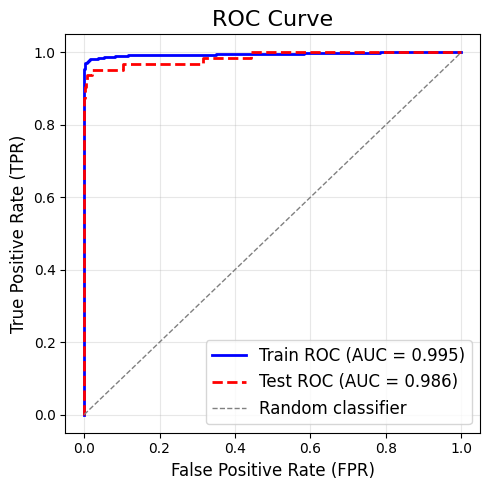

In [11]:
from experiments_utils import plot_roc_curve

plot_roc_curve(pipeline, X_train_1comma25, y_train_1comma25, X_test, y_test)


Notes:

In [12]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {balanced_accuracy:.3f}")

f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.3f}")
    

Balanced Test Accuracy: 0.965
F0.5-Score: 0.875


Notes:

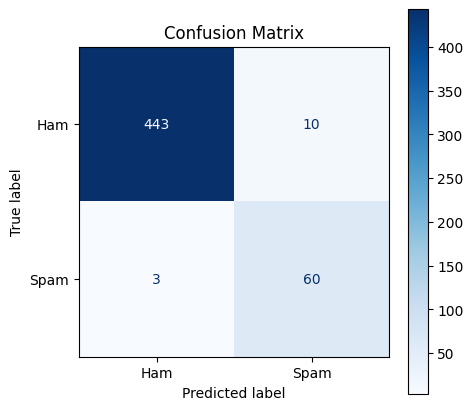

In [13]:
from experiments_utils import plot_confusion_matrix

matrix_fig = plot_confusion_matrix(y_test, y_test_pred)


Notes

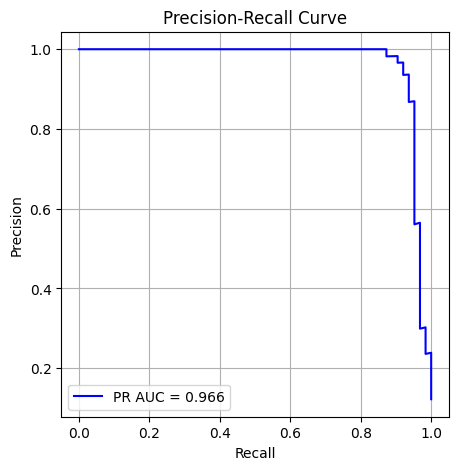

In [14]:
from experiments_utils import plot_precision_recall_curve

pr_fig = plot_precision_recall_curve(pipeline, X_test, y_test)

Notes:

## MLFlow config 1.25x

In [15]:
# # for testing 
# from dotenv import load_dotenv
# import os
# import mlflow

# load_dotenv()
# mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
# aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
# aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
# aws_default_region = os.getenv("AWS_DEFAULT_REGION")

# mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))



# sys.path.append("../utils")
# sys.stdout.flush()

# from experiments_utils import experiment_status

# experiment_name, _, _ = experiment_status()
# mlflow.set_experiment(experiment_name)


# import boto3
# boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=aws_default_region)

In [16]:
import mlflow
from experiments_utils import experiment_status

mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(mlflow_tracking_uri)
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

2024-12-30 16:02:25,098 - INFO - Loading configuration from: /home/maldu/dscience/projects/spam_detector/research/utils/experiments_config.yaml
2024-12-30 16:02:25,100 - INFO - Configuration successfully loaded.


2024/12/30 16:02:25 INFO mlflow.tracking.fluent: Experiment with name 'spam-classifier' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/maldu/dscience/projects/spam_detector/research/03_text_augmentation/mlruns/663238117327208753', creation_time=1735570945109, experiment_id='663238117327208753', last_update_time=1735570945109, lifecycle_stage='active', name='spam-classifier', tags={}>

In [17]:
from mlflow.models import infer_signature

signature = infer_signature(X_train, y_train)

## MLFlow tracking 1.25x

In [ ]:
logging.info('Initializing experiment...')

try: 
    
    with mlflow.start_run(run_name="textAug-SpellingAug1comma25x-BOW-MNB", log_system_metrics=True) as run:
        logging.info('Setting tags on MLFlow...')
        # Tags
        mlflow.set_tag("dataset", "Spam detection")
        mlflow.set_tag("task", "classification")
        mlflow.set_tag("vectorizer", "CountVectorizer")
        mlflow.set_tag("augmentation_type", "SpellingAug_1comma25x")
        mlflow.set_tag("model_type", "Multinomial Naive Bayes")
        mlflow.set_tag("framework", "Scikit-learn")
        mlflow.set_tag("language", "Python")
        mlflow.set_tag("environment", "Local")
        mlflow.set_tag("dataset_version", "0.1.0")
        mlflow.set_tag("preprocessing_version", "0.1.0")
        mlflow.set_tag("model_version", "0.1.0")
        mlflow.set_tag("developer", "Mldu")
        mlflow.set_tag("project_stage", "testing")

        logging.info('Logging inputs on MLFlow...')
        #Datasets


        logging.info('Logging params on MLFlow...')
        #BOW and model
        mlflow.log_param("vectorizer_type", "CountVectorizer")
        mlflow.log_param("model_type", "MultinomialNB")
        
        logging.info('Logging metrics on MLFlow...')
        # Metrics
        mlflow.log_metric("balanced_accuracy", balanced_accuracy)
        mlflow.log_metric("f0_5_score", f0_5_score)
        cr = classification_report(y_test, y_test_pred, output_dict=True)
        mlflow.log_metric("accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                mlflow.log_metric(class_or_avg + '_' + metric,value)
                
        logging.info('Logging figures on MLFlow...')
        # Figures
        mlflow.log_figure(matrix_fig, "confusion-matrix.png")
        mlflow.log_figure(pr_fig, "precision-recall-curve.png")
        
        
        logging.info('Logging pipeline on MLFlow...')
        # CountVectorizer and MNB
        mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)


except Exception as e:
    logging.error(f'Error executing MLflow commands {e}')

logging.info('MlFlow run terminated')

## Pipeline 1.5x

In [18]:
pipeline.fit(X_train_1comma5, y_train_1comma5)
y_train_pred = pipeline.predict(X_train_1comma5)
y_test_pred = pipeline.predict(X_test)


## Metrics 1.5x

In [19]:
from experiments_utils import print_classification_reports

print_classification_reports(y_train_1comma5, y_train_pred, y_test, y_test_pred)


Classification Report (Train Data):
              precision    recall  f1-score   support

         ham      0.995     0.994     0.995      3606
        spam      0.972     0.978     0.975       775

    accuracy                          0.991      4381
   macro avg      0.984     0.986     0.985      4381
weighted avg      0.991     0.991     0.991      4381

Classification Report (Test Data):
              precision    recall  f1-score   support

         ham      0.993     0.971     0.982       453
        spam      0.822     0.952     0.882        63

    accuracy                          0.969       516
   macro avg      0.908     0.962     0.932       516
weighted avg      0.972     0.969     0.970       516



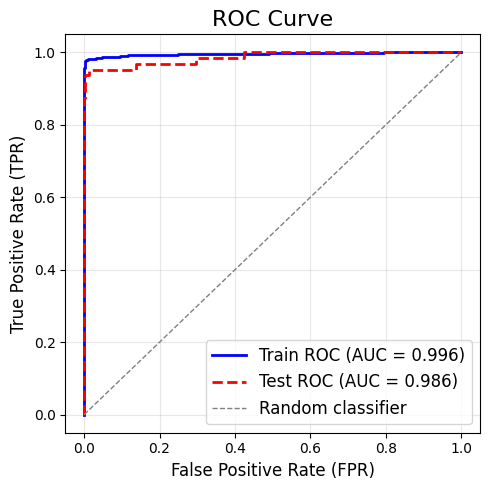

In [20]:
from experiments_utils import plot_roc_curve

plot_roc_curve(pipeline, X_train_1comma5, y_train_1comma5, X_test, y_test)

In [21]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {balanced_accuracy:.3f}")

f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.3f}")
    

Balanced Test Accuracy: 0.962
F0.5-Score: 0.845


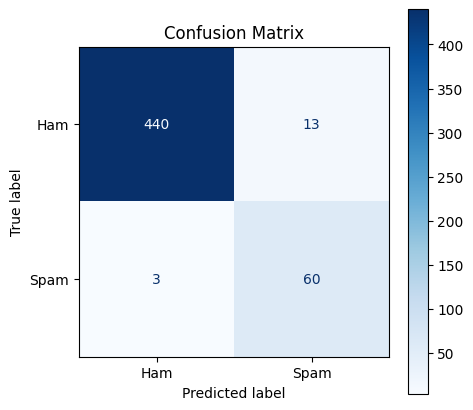

In [22]:
from experiments_utils import plot_confusion_matrix

matrix_fig = plot_confusion_matrix(y_test, y_test_pred)


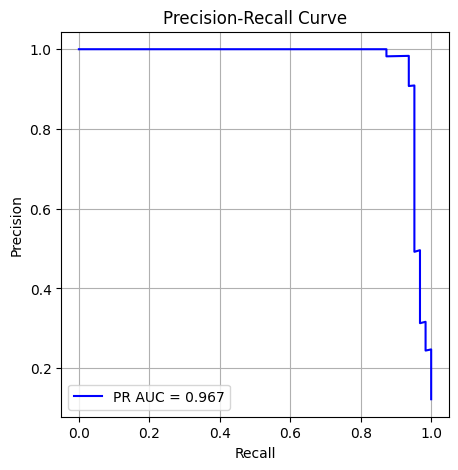

In [23]:
from experiments_utils import plot_precision_recall_curve

pr_fig = plot_precision_recall_curve(pipeline, X_test, y_test)

## MLFlow config 1.5x

In [ ]:
# # for testing 
# from dotenv import load_dotenv
# import os
# import mlflow

# load_dotenv()
# mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
# aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
# aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
# aws_default_region = os.getenv("AWS_DEFAULT_REGION")

# mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))



# sys.path.append("../utils")
# sys.stdout.flush()

# from experiments_utils import experiment_status

# experiment_name, _, _ = experiment_status()
# mlflow.set_experiment(experiment_name)


# import boto3
# boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=aws_default_region)

In [24]:
import mlflow
from experiments_utils import experiment_status

mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(mlflow_tracking_uri)
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

2024-12-30 16:03:15,630 - INFO - Loading configuration from: /home/maldu/dscience/projects/spam_detector/research/utils/experiments_config.yaml
2024-12-30 16:03:15,632 - INFO - Configuration successfully loaded.


<Experiment: artifact_location='file:///home/maldu/dscience/projects/spam_detector/research/03_text_augmentation/mlruns/663238117327208753', creation_time=1735570945109, experiment_id='663238117327208753', last_update_time=1735570945109, lifecycle_stage='active', name='spam-classifier', tags={}>

In [ ]:
from mlflow.models import infer_signature

signature = infer_signature(X_train, y_train)

## MLFlow tracking 1.5x

In [ ]:
logging.info('Initializing experiment...')

try: 
    
    with mlflow.start_run(run_name="textAug-SpellingAug1comma5x-BOW-MNB", log_system_metrics=True) as run:
        logging.info('Setting tags on MLFlow...')
        # Tags
        mlflow.set_tag("dataset", "Spam detection")
        mlflow.set_tag("task", "classification")
        mlflow.set_tag("vectorizer", "CountVectorizer")
        mlflow.set_tag("augmentation_type", "SpellingAug_1comma5x")
        mlflow.set_tag("model_type", "Multinomial Naive Bayes")
        mlflow.set_tag("framework", "Scikit-learn")
        mlflow.set_tag("language", "Python")
        mlflow.set_tag("environment", "Local")
        mlflow.set_tag("dataset_version", "0.1.0")
        mlflow.set_tag("preprocessing_version", "0.1.0")
        mlflow.set_tag("model_version", "0.1.0")
        mlflow.set_tag("developer", "Mldu")
        mlflow.set_tag("project_stage", "testing")

        logging.info('Logging inputs on MLFlow...')
        #Datasets


        logging.info('Logging params on MLFlow...')
        #BOW and model
        mlflow.log_param("vectorizer_type", "CountVectorizer")
        mlflow.log_param("model_type", "MultinomialNB")
        
        logging.info('Logging metrics on MLFlow...')
        # Metrics
        mlflow.log_metric("balanced_accuracy", balanced_accuracy)
        mlflow.log_metric("f0_5_score", f0_5_score)
        cr = classification_report(y_test, y_test_pred, output_dict=True)
        mlflow.log_metric("accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                mlflow.log_metric(class_or_avg + '_' + metric,value)
                
        logging.info('Logging figures on MLFlow...')
        # Figures
        mlflow.log_figure(matrix_fig, "confusion-matrix.png")
        mlflow.log_figure(pr_fig, "precision-recall-curve.png")
        
        
        logging.info('Logging pipeline on MLFlow...')
        # CountVectorizer and MNB
        mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)


except Exception as e:
    logging.error(f'Error executing MLflow commands {e}')

logging.info('MlFlow run terminated')

## Pipeline 2x

In [ ]:
pipeline.fit(X_train_2comma0, y_train_2comma0)
y_train_pred = pipeline.predict(X_train_2comma0)
y_test_pred = pipeline.predict(X_test)

## Metrics 2x

In [25]:
from experiments_utils import print_classification_reports

print_classification_reports(y_train_2comma0, y_train_pred, y_test, y_test_pred)


ValueError: Found input variables with inconsistent numbers of samples: [4252, 4381]

In [ ]:
from experiments_utils import plot_roc_curve

plot_roc_curve(pipeline, X_train_2comma0, y_train_2comma0, X_test, y_test)


In [ ]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {balanced_accuracy:.3f}")

f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.3f}")
    

In [ ]:
from experiments_utils import plot_confusion_matrix

matrix_fig = plot_confusion_matrix(y_test, y_test_pred)


In [ ]:
from experiments_utils import plot_precision_recall_curve

pr_fig = plot_precision_recall_curve(pipeline, X_test, y_test)

## MLFlow config 2x

In [ ]:
# # for testing 
# from dotenv import load_dotenv
# import os
# import mlflow

# load_dotenv()
# mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
# aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
# aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
# aws_default_region = os.getenv("AWS_DEFAULT_REGION")

# mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))



# sys.path.append("../utils")
# sys.stdout.flush()

# from experiments_utils import experiment_status

# experiment_name, _, _ = experiment_status()
# mlflow.set_experiment(experiment_name)


# import boto3
# boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=aws_default_region)

In [ ]:
import mlflow
from experiments_utils import experiment_status

mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(mlflow_tracking_uri)
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

In [ ]:
from mlflow.models import infer_signature

signature = infer_signature(X_train, y_train)

## MLFlow Tracking 2x

In [ ]:
logging.info('Initializing experiment...')

try: 
    
    with mlflow.start_run(run_name="textAug-SpellingAug2x-BOW-MNB", log_system_metrics=True) as run:
        logging.info('Setting tags on MLFlow...')
        # Tags
        mlflow.set_tag("dataset", "Spam detection")
        mlflow.set_tag("task", "classification")
        mlflow.set_tag("vectorizer", "CountVectorizer")
        mlflow.set_tag("augmentation_type", "SpellingAug_2x")
        mlflow.set_tag("model_type", "Multinomial Naive Bayes")
        mlflow.set_tag("framework", "Scikit-learn")
        mlflow.set_tag("language", "Python")
        mlflow.set_tag("environment", "Local")
        mlflow.set_tag("dataset_version", "0.1.0")
        mlflow.set_tag("preprocessing_version", "0.1.0")
        mlflow.set_tag("model_version", "0.1.0")
        mlflow.set_tag("developer", "Mldu")
        mlflow.set_tag("project_stage", "testing")

        logging.info('Logging inputs on MLFlow...')
        #Datasets


        logging.info('Logging params on MLFlow...')
        #BOW and model
        mlflow.log_param("vectorizer_type", "CountVectorizer")
        mlflow.log_param("model_type", "MultinomialNB")
        
        logging.info('Logging metrics on MLFlow...')
        # Metrics
        mlflow.log_metric("balanced_accuracy", balanced_accuracy)
        mlflow.log_metric("f0_5_score", f0_5_score)
        cr = classification_report(y_test, y_test_pred, output_dict=True)
        mlflow.log_metric("accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                mlflow.log_metric(class_or_avg + '_' + metric,value)
                
        logging.info('Logging figures on MLFlow...')
        # Figures
        mlflow.log_figure(matrix_fig, "confusion-matrix.png")
        mlflow.log_figure(pr_fig, "precision-recall-curve.png")
        
        
        logging.info('Logging pipeline on MLFlow...')
        # CountVectorizer and MNB
        mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)


except Exception as e:
    logging.error(f'Error executing MLflow commands {e}')

logging.info('MlFlow run terminated')